In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


2023-02-25 16:46:24.688029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 16:46:25.083457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-25 16:46:25.083493: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-25 16:46:26.213096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


68606236/68606236 [==============================] - 12s 0us/step
Found 2000 files belonging to 2 classes.


2023-02-25 16:46:52.103549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 16:46:52.103570: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 16:46:52.103585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eduLU): /proc/driver/nvidia/version does not exist
2023-02-25 16:46:52.104762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [8]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 7s 1us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


2023-02-25 16:54:41.788361: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2023-02-25 16:54:41.836912: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2023-02-25 16:54:41.847174: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2023-02-25 16:54:41.856525: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2023-02-25 16:54:41.865323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.


(32, 5, 5, 1280)


In [10]:
base_model.trainable = False


In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 6s 198ms/step - loss: 0.8735 - accuracy: 0.4394


In [18]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
63/63 [==============================] - 22s 290ms/step - loss: 0.7872 - accuracy: 0.5135 - val_loss: 0.5833 - val_accuracy: 0.6683
Epoch 2/10
63/63 [==============================] - 19s 296ms/step - loss: 0.5735 - accuracy: 0.6740 - val_loss: 0.4290 - val_accuracy: 0.7946
Epoch 3/10
63/63 [==============================] - 17s 269ms/step - loss: 0.4648 - accuracy: 0.7475 - val_loss: 0.3337 - val_accuracy: 0.8478
Epoch 4/10
63/63 [==============================] - 17s 276ms/step - loss: 0.3820 - accuracy: 0.8115 - val_loss: 0.2831 - val_accuracy: 0.8700
Epoch 5/10
63/63 [==============================] - 18s 279ms/step - loss: 0.3299 - accuracy: 0.8385 - val_loss: 0.2351 - val_accuracy: 0.8899
Epoch 6/10
63/63 [==============================] - 17s 268ms/step - loss: 0.3030 - accuracy: 0.8560 - val_loss: 0.2069 - val_accuracy: 0.9134
Epoch 7/10
63/63 [==============================] - 17s 268ms/step - loss: 0.2740 - accuracy: 0.8670 - val_loss: 0.1872 - val_accuracy: 0.9233

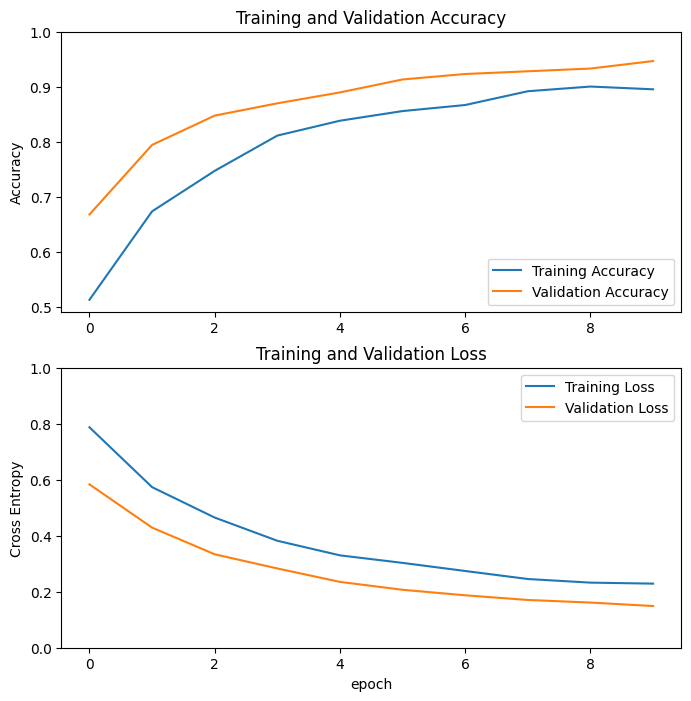

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [20]:
base_model.trainable = True


In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 31s 400ms/step - loss: 0.1697 - accuracy: 0.9190 - val_loss: 0.0651 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 24s 389ms/step - loss: 0.1148 - accuracy: 0.9525 - val_loss: 0.0606 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 27s 425ms/step - loss: 0.1020 - accuracy: 0.9590 - val_loss: 0.0508 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 24s 388ms/step - loss: 0.0836 - accuracy: 0.9625 - val_loss: 0.0516 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 26s 419ms/step - loss: 0.0966 - accuracy: 0.9600 - val_loss: 0.0473 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 25s 395ms/step - loss: 0.0861 - accuracy: 0.9630 - val_loss: 0.0568 - val_accuracy: 0.9728
Epoch 16/20
63/63 [==============================] - 25s 390ms/step - loss: 0.0803 - accuracy: 0.9710 - val_loss: 0.0384 - val_accuracy:

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


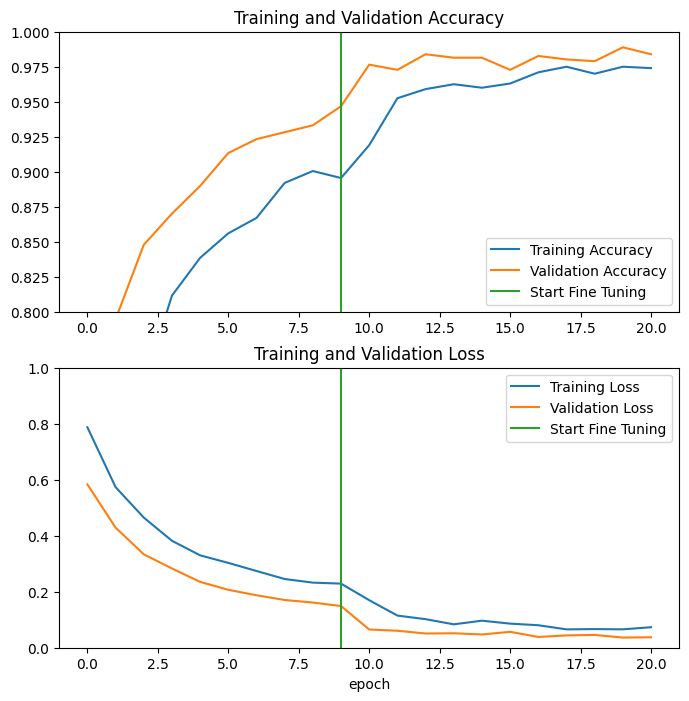

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
